# Lightning to PyTorch: CIFAR-10 Classifier Comparison

This notebook is part of my prep for developing skills as a research engineer in alignment science role

The goal is to deeply understand PyTorch Lightning abstractions by:
- Annotating every major component of the Lightning CIFAR-10 example
- Rebuilding the same pipeline in plan PyTorch side-by-side
- Documenting what Lightning automates or hides

## Part 1: Vanilla PyTorch Training Loop

## Part 2: Lightning 

### Step 1: Import Python and Pytorch Libraries

We import standard Python Libraries, Pytorch core components, and torchvision.

In [1]:
import os
import torch
import torchvision

### Step 2: Import Functional Tools and Dataset Utilities

We'll use functional tools like 'F.cross_entropy' (calculates classification loss in the training step of the model) and dataset helpers like 'transforms' (preprocesses images when loading image data to the model)

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR10


### Step 3: Import PyTorch Lightning Core Tools

We import the core PyTorch Lightning classes for model training and reproducibility.


In [3]:
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer, seed_everything


### Step 4: Set a Seed for Reproducibility

We fix the random seed to ensure experiments are reproducible. 

In [4]:
seed_everything(42)


Seed set to 42


42

### Step 5: Define Transform for CIFAR-10

CIFAR-10 images are 32x32 color images (3 channels, RGB). We apply:
- 'ToTensor()' to conver PIL images to PyTorch tensors
- 'Normalize()' to scale pixel values form [0,1] to [-1,1]
This helps model learn better and faster.

The below is a data transformation pipeline to proprocess the images.
- transforms.ToTensor() converts image to tensor, scales to [0.0, 1.0] e.g. before: pixel value is 128 out of 255, after ToTensor: 128/255 = ~0.502
- transforms.Normalize(...) shifts and scales to [-1,1] per channel (R, G, B) e.g. after Normalize (0.502 - 0.5) / 0.5 = ~ 0.004 / 0.5 = ~ 0.008: pixel value of 0 become - 1, a pixel value of 1 becomes + 1 so range is roughly [-1, 1]
- transforms.Compose([...]) chains the two steps into one transformation 


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Step 6: Download the CIFAR-10 Trainig Set

We use 'torchvision.datasets.CIFAR10' to download the training portion of the dataset
We apply the transform so that each image is automatically preprocessed when accessed. 

Notes:
root='.' -> saves data in the current directory
train=True -> selects the training set (train=False for test set)
download=True -> downloads the dataset if not already present
transform=transfrom -> applies the transform preprocessing pipeline to each image when it is loaded

In [6]:

cifar_train = CIFAR10(root='.', train=True, download=True, transform=transform)

100%|█████████████████████████████████████| 170M/170M [02:51<00:00, 992kB/s]


### Step 7: Split CIFAR-10 Training Set into Training and Validation Set

We split the 50,000 training images into:
- 45,0000 for training
- 5,000 for validation

So we can monitor how well the model is generalizing during training.

In [7]:
cifar_train, cifar_val = random_split(cifar_train, [45000, 5000])

### Step 8: Create DataLoaders for Training and Validation Sets

We now create PyTorch DataLoaders to:
- Shuffle and batch the training data
- Batch (but not shuffle) the validation data

Batch size controls how many images the model sees at once during training

Notes:
- for validation, we don't shuffle to ensure consistency
- can't load 50,000 images into GPU memory at once so DataLoader gives small manageable chunks
- Models learn better when trained on mini-batches rather than single images or full dataset
- batch size of 64 images at a time is a common default as a good trade-off between speed and stability (less memory, sometimes better generalization)

In [8]:
train_loader = DataLoader(cifar_train, batch_size=64, shuffle=True)
val_loader = DataLoader(cifar_val, batch_size=64)

### Step 9: Define the CNN Model Architecture

We define a simple Convolutional Neural Network (CNN) using Pytorch's 'nn.Module'. It has:
- Two convolutional layers
- ReLU activations and max pooling
- Two fully connected (linear) layers
Takes a 3 x 32 x 32 image and outputs 10 class scores (for CIFAR-10).

#### Step 9.1: Import CNN and activation libraries

We import the core building blocks to define neural networks.
- `nn.Module` for model classes
- `Conv2d`, `Linear`, etc. for layers
- `F.relu()` for activation


#### Step 9.2: Define the CNN Model Class

We create a class `SimpleCNN` that extends `nn.Module`. This is how all PyTorch models are structured.


#### Step 9.3: First Convolutional Layer

This layer:
- Takes RGB images (3 channels)
- Applies 32 filters of size 3x3
- Uses padding=1 to keep spatial dimensions the same

Output: [B, 32, 32, 32]


#### Step 9.4: Max Pooling Layer

Reduces each spatial dimension by half (32x32 -> 16x16) using a 2x2 max filter.
This reduces computation and focuses on st

#### Step 9.5: Second Convolutional Layer

Applies 64 filters to the output of the first pooled layer.

Again uses padding=1 to preserve dimensions before pooling.


#### Step 9.6: First Fully Connected (Linear) Layer

- After second pooling: output is [B, 64, 8, 8]
- We flatten this to [B, 4096] before feeding into a dense layer

This layer reduces 4096 features to 256.


#### Step 9.7: Output Layer

This layer maps the 256 features to 10 output scores (one for each CIFAR-10 class).


#### Step 9.8: Define the Forward Pass

This method defines how the input flows through the network layers.


##### Note: the entire class SimpleCNN must be one block so Python knows how to build the object correctly.

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # First conv layer: in_channels=3 (RGB), out_channels=32, kernel=3x3
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Second conv layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Flattening and linear layers
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # 8x8 is the output size after 2 poolings
        self.fc2 = nn.Linear(256, 10)  # 10 classes in CIFAR-10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [batch, 32, 16, 16]
        x = self.pool(F.relu(self.conv2(x)))  # -> [batch, 64, 8, 8]
        x = x.view(-1, 64 * 8 * 8)            # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Step 10: Run a Forward Pass with Dummpy Input

We'll create a fake batch of CIFAR-10 images (3 channels, 32x32), pass it through the model, and check the output shape.

Expected output: [batch_size, 10] - the logits for 10 classes.

In [10]:
# Step 1: Create a fake batch of images
# Shape: [batch_size, channels, height, width]
dummy_images = torch.randn(8, 3, 32, 32)  # batch of 8 RGB images

# Step 2: Instantiate the model
model = SimpleCNN()

# Step 3: Forward pass
outputs = model(dummy_images)

# Step 4: Print the output shape
print("Output shape:", outputs.shape)


Output shape: torch.Size([8, 10])


### Step 11: Setup Training Tools (Vanilla Pytorch)

Training loop is the heart of deep learning. Basic idea:
For each epoch (a full pass through dataset):
1. Loop through mini-batches of your training data
2. For each batch:
   Run the model's forward pass (input -> model -> output; see how well the model is performing)
   Compute the loss
   Run backward pass to compute gradients (loss -> derivatives -> backpropagation; figure out how to adjust the weights)
   Update weights using the optimizer
3. Optionally evaluate on validation data

Forward pass - throw the dart and see where it lands - how wrong am I?
Backward pass - calculate how to adjust your arm to get closer next time

We now define:
- The **loss function**: Cross-entropy for classification
- The **optimizer**: Adam optimizer for parameter updates
- The **device**: Use GPU if available, otherwise CPU

In [11]:
# Step 1: Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Step 2: Instantiate model and move it to device
model = SimpleCNN().to(device)

# Step 3: Define loss function
criterion = nn.CrossEntropyLoss()

# Step 4: Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Using device: cpu


### Step 12: Training & Validation Loop (Vanilla PyTorch)

We'll train the model for a few epochs using the training DataLoader.
Each epoch consists of:
1. Forward pass - to compute predictions
2. Loss calculation - to measure error
3. Backward pass - to compute gradients
4. Optimizer step - to update weights

We'll also print the avergae training loss per epoch.

After each training epoch, we evaluate the model on the validation set:
- We turn off gradient tracking with `torch.no_grad()`
- We compute the average loss and accuracy on the validation data
- We print these metrics to monitor generalization



In [42]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


In [43]:
num_epochs = 5
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # --- Training loop ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()              # Step 1: Reset gradients
        outputs = model(inputs)            # Step 2: Forward pass
        loss = criterion(outputs, labels)  # Step 3: Compute loss
        loss.backward()                    # Step 4: Backpropagation
        optimizer.step()                   # Step 5: Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct / total if total > 0 else 0.0

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # --- Validation loop ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total if total > 0 else 0.0

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # --- Epoch summary ---
    
    print(f"Epoch {epoch + 1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/5 | Train Loss: 0.0831 | Train Acc: 0.9714 | Val Loss: 1.4243 | Val Acc: 0.7274
Epoch 2/5 | Train Loss: 0.0698 | Train Acc: 0.9758 | Val Loss: 1.5280 | Val Acc: 0.7158
Epoch 3/5 | Train Loss: 0.0729 | Train Acc: 0.9748 | Val Loss: 1.7191 | Val Acc: 0.7110
Epoch 4/5 | Train Loss: 0.0438 | Train Acc: 0.9853 | Val Loss: 1.8500 | Val Acc: 0.7182
Epoch 5/5 | Train Loss: 0.0513 | Train Acc: 0.9823 | Val Loss: 1.7876 | Val Acc: 0.7108


In [45]:
epochs = list(range(1, num_epochs + 1))


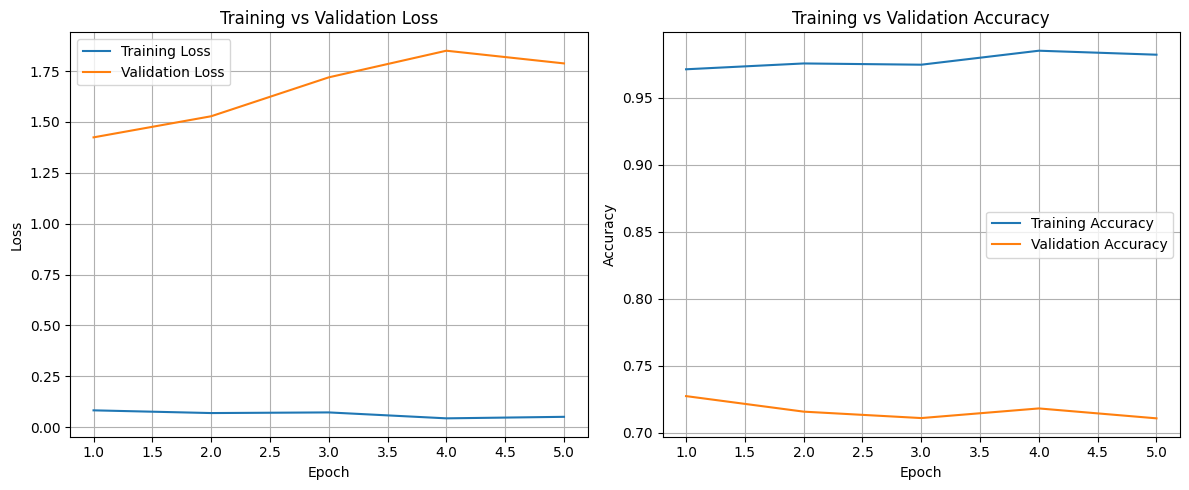

In [46]:
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(12, 5))

# ---- Loss plot ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# ---- Accuracy plot ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Step 14: Evaluate the Model on the CIFAR-10 Test Set

The test set consists of 10,000 examples that were not used in training or validation.

We:
- Download the test dataset and apply the same transform
- Create a DataLoader for batching
- Evaluate the model’s final performance on this unseen data

This is the best estimate of how well our model will generalize in the real world.


In [47]:
# Step 1: Load the CIFAR-10 test set
cifar_test = CIFAR10(root='.', train=False, download=True, transform=transform)
test_loader = DataLoader(cifar_test, batch_size=64)

# Step 2: Set model to evaluation mode
model.eval()

# Step 3: Initialize counters
test_loss = 0.0
correct = 0
total = 0

# Step 4: Run inference
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Step 5: Compute final metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 1.8423, Test Accuracy: 0.7060


In [48]:
# Save model parameters to a file
torch.save(model.state_dict(), "simple_cnn.pth")
print("Model weights saved to simple_cnn.pth")


Model weights saved to simple_cnn.pth


## Translation to PyTorch Lightning version

### Step 1: Import PyTorch Lightning

We import the core Lightning module that lets us wrap our model in a training framework.


In [49]:
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer

### Step 2: Define LightningModule to Wrap the CNN

We create a `LitCNN` class that extends `LightningModule`.

This class defines:
- The model (`self.model`)
- Training logic (`training_step`)
- Validation logic (`validation_step`)
- Optimizer (`configure_optimizers`)


e create a new class `LitCNN` that inherits from `LightningModule`. This class wraps our original `SimpleCNN` model and handles:

#### 🔧 Model Instantiation (`__init__`)
- We create an instance of our original CNN (`SimpleCNN`) and assign it to `self.model`
- We define a loss function (`CrossEntropyLoss`) to compare predicted vs. true labels

#### 🔁 Forward Pass (`forward`)
- This is a wrapper around `self.model(x)`
- It's used when the Trainer or another function calls `model(x)` internally

#### 📉 Training Step (`training_step`)
- This method is called **once per batch** during training
- It receives a batch of data: `x` (inputs) and `y` (true labels)
- It runs the forward pass to get predictions (logits)
- Computes the loss using the criterion
- Logs the loss using `self.log()` so Lightning can track metrics

#### ✅ Validation Step (`validation_step`)
- Same idea as `training_step`, but used on the validation set
- In addition to loss, we also calculate accuracy:
  - We take the class with the highest logit (`argmax`)
  - We compare it to the ground truth and average over the batch

#### ⚙️ Optimizer Setup (`configure_optimizers`)
- We define and return our optimizer here (Adam in this case)
- Lightning will automatically call `optimizer.step()` for us each batch

---

**✨ Benefits of Lightning:**
- We no longer have to manually write training loops, validation loops, or optimizer steps
- All the common training infrastructure is handled by the `Trainer`
- We can scale up (e.g., to multi-GPU) or log metrics easily without changing model code

Once this class is defined, we’ll use `Trainer.fit()` to train it, passing in data and hyperparameters.


In [50]:
class LitCNN(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = SimpleCNN()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):  # <-- THIS PART MUST BE INSIDE THE CLASS
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


### Step 3: Train the Lightning Model Using Trainer

PyTorch Lightning’s `Trainer` class handles:
- Training loop
- Validation after each epoch
- Progress bars and logging
- GPU/CPU device management

We just pass in:
- Our `LitCNN` model
- Number of training epochs
- DataLoaders for training and validation


In [51]:
from pytorch_lightning import Trainer

# Step 1: Instantiate the Lightning-wrapped model
lit_model = LitCNN()

# Step 2: Create a Trainer (automatic GPU if available)
trainer = Trainer(max_epochs=5, accelerator='auto')

# Step 3: Train the model
trainer.fit(lit_model, train_dataloaders=train_loader, val_dataloaders=val_loader)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Volumes/Stay-C SSD/AI Projects/torch-utils/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleCNN        | 1.1 M  | train
1 | cri

Sanity Checking: |                                    | 0/? [00:00<?, ?it/s]

/Volumes/Stay-C SSD/AI Projects/torch-utils/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Volumes/Stay-C SSD/AI Projects/torch-utils/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                         | 0/? [00:00<?, ?it/s]

Validation: |                                         | 0/? [00:00<?, ?it/s]

Validation: |                                         | 0/? [00:00<?, ?it/s]

Validation: |                                         | 0/? [00:00<?, ?it/s]

Validation: |                                         | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


### Step 4: Evaluate the Trained Model on the Test Set

Now that the model is trained, we’ll evaluate it on the official CIFAR-10 test set.
We'll:
- Load the test data with the same transform
- Wrap it in a DataLoader
- Use `trainer.test()` to run evaluation


In [52]:
trainer.test(model=lit_model, dataloaders=test_loader)

/Volumes/Stay-C SSD/AI Projects/torch-utils/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |                                            | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7218999862670898
        test_loss            0.829054594039917
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.829054594039917, 'test_acc': 0.7218999862670898}]

In [53]:
# Save the model weights to disk
torch.save(lit_model.state_dict(), "lit_cnn_weights.pth")
print("Model weights saved to lit_cnn_weights.pth")


Model weights saved to lit_cnn_weights.pth


## Comparison with PyTorch Lightning

Using PyTorch Lightning resulted in a slightly lower validation loss (~0.83 vs ~1.78) with similar validation accuracy (~71%). While the core model and data loaders remained the same, Lightning's abstraction may have helped with more consistent training behavior (e.g., automatic `.eval()` handling, checkpointing, device management).

Overall, the takeaway is that Lightning improves code structure and reliability, especially for scaling or experimenting — but performance still depends on model capacity, data handling, and regularization.


## 📌 Reflection & Conclusion

From the training and validation curves above, it’s clear that the model quickly achieves high accuracy on the training data, with a very low training loss. However, the validation loss increases steadily while accuracy plateaus around 71–73%.

This indicates **overfitting** — the model is memorizing the training data but failing to generalize well to unseen examples.

### 🔍 Likely Causes
- **Lack of regularization**: The current model doesn’t use dropout or weight decay.
- **No data augmentation**: Images are passed as-is without techniques like flipping or cropping.
- **Model capacity**: Even a simple CNN can overfit CIFAR-10 without proper generalization techniques.

### 🛠️ Next Steps for Improvement
- Add **dropout layers** between fully connected layers.
- Apply **data augmentation** during training (e.g. `RandomCrop`, `RandomHorizontalFlip`).
- Introduce **weight decay** in the optimizer.
- Experiment with **longer training** and **early stopping** based on validation loss.

Despite the overfitting, this was a valuable learning exercise in building, training, and evaluating CNNs in both **vanilla PyTorch** and **PyTorch Lightning**. It sets a solid foundation for future deep learning experiments.


### Why I Didn't Use a LightningDataModule Initially — and When It's Useful

In this notebook, I used **explicit PyTorch DataLoaders (`train_loader`, `val_loader`, `test_loader`)** rather than implementing a `LightningDataModule` from the start.

This was intentional for the following reasons:

#### ✅ 1. Focus on Learning Core Concepts
For this first round of experimentation, my primary goal was to:
- Understand how PyTorch Lightning abstracts away training loops
- Learn how to implement a model, training, validation, and testing steps manually
- See the full lifecycle of a model in Lightning from scratch

Using raw `DataLoader`s helped me see **exactly what Lightning is doing**, without the added abstraction of a separate data module.

#### ✅ 2. Faster Iteration While Prototyping
When you're:
- Trying out different batch sizes
- Quickly switching between datasets
- Experimenting with transforms
...it's often faster to work directly with `DataLoader`s and tweak inline.

---

### ⚙️ When to Use a LightningDataModule (and Why It's Powerful)

As projects grow in complexity, `LightningDataModule` becomes extremely useful:

#### ✅ Cleaner Organization
All data loading logic — downloading, splitting, transforming — lives in one reusable class. This avoids copy-pasting DataLoader code between notebooks or scripts.

#### ✅ Reusability
You can plug the same `DataModule` into different models or experiments — making your codebase modular and scalable.

#### ✅ Production Readiness
If you're deploying a model or running long training jobs:
- `prepare_data()` only downloads once (on one process)
- `setup()` runs at the right time per training/validation/test phase
- Easy to switch between CPU, GPU, or distributed systems

#### ✅ Compatibility with `Trainer.predict()`, `Trainer.test()`, CLI training, etc.

---

### 🧠 Summary

Using explicit DataLoaders helped me:
- Learn PyTorch Lightning’s core logic
- Stay hands-on with each step
- Build confidence in manual training loop concepts

But for cleaner long-term experiments, I’ve now transitioned to a `CIFAR10DataModule` for better structure and scalability.


### Why Performance Improvement Strategies Are Important for Future Development

Once a model is successfully training and evaluating, the next step is to explore ways to **improve performance**, especially generalization to unseen data.

Neural networks can often achieve **much higher accuracy** and robustness with a few thoughtful upgrades to data, architecture, or training setup.

Below are common strategies that are broadly applicable in deep learning workflows:

---

#### 🔁 1. Training for More Epochs
- Training for a small number of epochs is great for prototyping.
- For better performance, more epochs can allow the model to learn richer patterns.
- Always monitor validation loss to avoid overfitting.

---

#### 🖼️ 2. Data Augmentation
- Applying random transformations (flips, crops, noise) makes training data more diverse.
- Improves the model’s ability to generalize beyond what it has seen.
- Especially effective on small or fixed-size datasets like CIFAR-10.

---

#### 🧠 3. Using a Deeper or Pretrained Architecture
- Simple models are great for learning, but deeper architectures (like ResNet, VGG, etc.) often perform much better.
- Pretrained models from `torchvision.models` can dramatically improve results with minimal setup.

---

#### 🎛️ 4. Hyperparameter Tuning
- Learning rate, optimizer choice, and batch size can have a huge impact on model convergence and stability.
- Systematic tuning or using libraries like `Optuna` can help discover better combinations.

---

#### 🧪 5. Regularization Techniques
- Dropout, weight decay (L2), or label smoothing help prevent overfitting.
- These methods are often easy to add and can significantly improve robustness.

---

#### 🧼 6. Early Stopping and Model Checkpointing
- Automatically save the best version of the model during training.
- Stop training if validation accuracy stops improving.
- Saves time and protects against overfitting.

---

### 🧠 Summary

These strategies offer a roadmap for improving model performance once the training pipeline is stable. They help:
- Boost accuracy
- Improve generalization
- Support robust, scalable model development

As experimentation continues, combining several of these techniques thoughtfully can make a significant difference in results.
